In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import tensorflow as tf

# Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

/kaggle/input/sf-dl-movie-genre-classification/test_data.txt
/kaggle/input/sf-dl-movie-genre-classification/sample-submission.csv
/kaggle/input/sf-dl-movie-genre-classification/train_data.txt
/kaggle/input/sf-dl-movie-genre-classification/train.csv
/kaggle/input/sf-dl-movie-genre-classification/test.csv


## Данные

In [2]:
DATA_PATH = '/kaggle/input/sf-dl-movie-genre-classification/'
PATH      = '/kaggle/working/'

In [3]:
train = pd.read_csv(DATA_PATH+'train.csv')
train.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Количество')

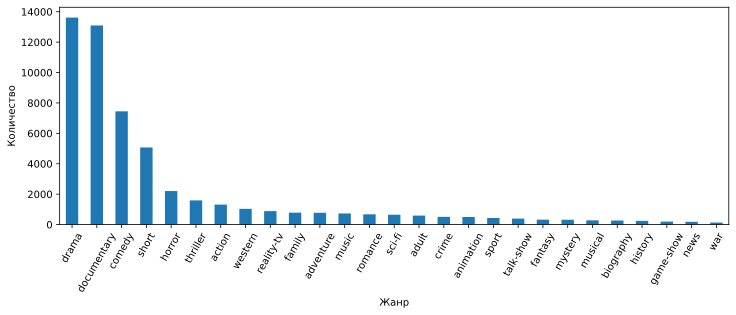

In [5]:
train.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Жанр",fontsize=10)
plt.ylabel("Количество",fontsize=10)

In [6]:
test = pd.read_csv(DATA_PATH+'test.csv',)
test.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


Кодировка таргета

In [7]:
le = LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])
CLASS_NUM = train['genre'].nunique()

train['genre']

0         8
1        24
2         1
3         8
4         8
         ..
54209     5
54210    13
54211     7
54212     5
54213    12
Name: genre, Length: 54214, dtype: int64

In [12]:
CLASS_NUM

27

## Модель

In [13]:
# Задаем модель
model_name = 'bert-base-uncased'

# Максимальная длинная токенов
max_length = 100

# Загружаем настройки и устанавливаем output_hidden_states - False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Загружаем встроенный токенизатор
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Загружаем модель
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-07-06 16:16:22.967130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 16:16:22.968576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 16:16:22.969602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 16:16:22.970803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Задаем архитектуру сети

In [14]:
# Основной слой
bert = transformer_model.layers[0]

# Входные данные
input_ids = Input(shape=(max_length), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Встраиваем в слой
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Выходные данные
genre = Dense(units=CLASS_NUM, activation = 'softmax',
              kernel_initializer=TruncatedNormal(stddev=config.initializer_range), 
              name='genre')(pooled_output)
outputs = {'genre': genre}

model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
genre (Dense)                (None, 27)                20763     
Total params: 109,503,003
Trainable params: 109,503,003
Non-trainable params: 0
_________________________________________________________________


Задаем параметры

In [15]:
# Оптимайзер
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Функция потерь
loss = {'genre': CategoricalCrossentropy(from_logits = True)}

# Метрика для функции потерь
metric = {'genre': CategoricalAccuracy('accuracy')}

# Компилируем модель
model.compile(optimizer = optimizer, loss = loss, metrics = metric)

# Кодируем выходные данные
y_genre = to_categorical(train['genre'])

# Токенизируем входные данные
x = tokenizer(
    text=train['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = False)

Обучаем модель

In [17]:
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'genre': y_genre},
    validation_split=0.2,
    batch_size=64,
    epochs=10)

2022-07-06 16:18:28.816781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


678/678 [==============================] - 549s 773ms/step - loss: 1.5277 - accuracy: 0.5755 - val_loss: 1.2939 - val_accuracy: 0.6331
Epoch 2/10
678/678 [==============================] - 520s 767ms/step - loss: 1.1738 - accuracy: 0.6691 - val_loss: 1.2310 - val_accuracy: 0.6435
Epoch 3/10
678/678 [==============================] - 520s 767ms/step - loss: 1.0724 - accuracy: 0.6979 - val_loss: 1.2226 - val_accuracy: 0.6471
Epoch 4/10
678/678 [==============================] - 520s 767ms/step - loss: 1.0140 - accuracy: 0.7131 - val_loss: 1.2083 - val_accuracy: 0.6492
Epoch 5/10
678/678 [==============================] - 520s 766ms/step - loss: 0.9714 - accuracy: 0.7270 - val_loss: 1.2122 - val_accuracy: 0.6480
Epoch 6/10
678/678 [==============================] - 519s 766ms/step - loss: 0.9394 - accuracy: 0.7371 - val_loss: 1.2096 - val_accuracy: 0.6483
Epoch 7/10
678/678 [==============================] - 519s 765ms/step - loss: 0.9152 - accuracy: 0.7417 - val_loss: 1.2165 - val_accura

График обучения

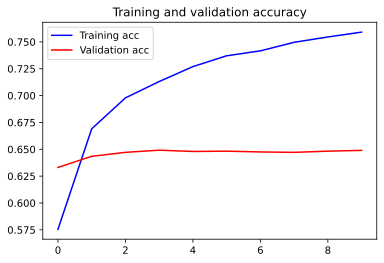

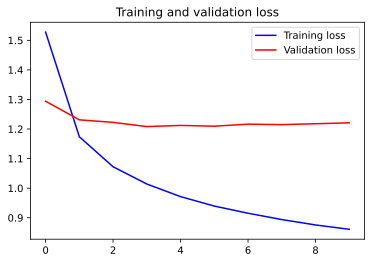

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

После 4-ой эпохи происходит переобучение модели

Сохраняем модель

In [19]:
model.save('best_model.h5')

Делаем предсказание

In [21]:
x_test = tokenizer(
    text=test['text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = False)

In [22]:
predictions = model.predict(x={'input_ids': x_test['input_ids']})
predictions

{'genre': array([[1.1729745e-03, 1.4318551e-03, 9.5086987e-04, ..., 1.0542565e-02,
         2.5090855e-04, 2.0463389e-04],
        [1.9557283e-03, 3.8448260e-03, 6.4623039e-03, ..., 4.5414683e-03,
         1.1428606e-03, 9.7627076e-04],
        [2.7379024e-04, 8.9068853e-05, 5.9173239e-04, ..., 1.8261683e-04,
         2.8061835e-04, 2.5643429e-04],
        ...,
        [9.2834549e-04, 2.2313569e-02, 5.4508583e-03, ..., 4.6332693e-03,
         3.3883881e-04, 2.5800841e-03],
        [3.1937801e-03, 6.5647960e-03, 2.8182715e-03, ..., 1.9719023e-02,
         1.2715684e-03, 2.3820193e-03],
        [6.6856394e-04, 4.0539147e-04, 8.2157837e-04, ..., 1.1585051e-03,
         1.0552404e-03, 4.3068200e-04]], dtype=float32)}

Сохраняем предсказание в датафрейм

In [23]:
sub_list = []
for i in range(len(predictions['genre'])):
    genr = np.argmax(predictions['genre'][i])
    sub_list.append(genr)
    
pd.DataFrame(sub_list)

,0
0,21
1,5
2,7
3,8
4,8
...,...
54195,8
54196,26
54197,5
54198,8


In [24]:
submission = pd.DataFrame(sub_list, columns=['genre'])

submission

,genre
0,21
1,5
2,7
3,8
4,8
...,...
54195,8
54196,26
54197,5
54198,8


Декодируем предсказание

In [25]:
submission['genre'] = le.inverse_transform(submission['genre'])

In [26]:
submission = pd.DataFrame({'id':range(1, len(submission)+1),
                           'genre':submission['genre'].values},
                          columns=['id', 'genre'])

Сохраняем в файл

In [27]:
submission.to_csv('submission.csv', index=False)

In [28]:
submission

,id,genre
0,1,short
1,2,comedy
2,3,documentary
3,4,drama
4,5,drama
...,...,...
54195,54196,drama
54196,54197,western
54197,54198,comedy
54198,54199,drama


In [29]:
submission.head()

,id,genre
0,1,short
1,2,comedy
2,3,documentary
3,4,drama
4,5,drama
